In [2]:
import os
import pickle
import numpy as np
import pandas as pd
import shapely
import geopandas as gpd
import xarray as xr
import rioxarray as rxr
import matplotlib.pyplot as plt

In [7]:
eog_tiles = gpd.GeoDataFrame(
    geometry = [
        shapely.box(-180, 0, -60, 75),
        shapely.box(-60, 0, 60, 75),
        shapely.box(60, 0, 180, 75),
        shapely.box(-180, -75, -60, 0),
        shapely.box(-60, -75, 60, 0),
        shapely.box(60, -75, 180, 0)
    ],
    crs = 4326
)

In [3]:
# import shoreline
if not os.path.exists("Q:/HEALECON/Felix/Research/Heat Islands/data/shoreline.pkl"):
    shoreline = gpd.read_file("Q:/HEALECON/Felix/Research/Heat Islands/data/ne_10m_admin_0_countries/ne_10m_admin_0_countries.shp", engine = "pyogrio")
    shoreline = shoreline.unary_union
    pickle.dump(shoreline, open("Q:/HEALECON/Felix/Research/Heat Islands/data/shoreline.pkl", "wb"))
else:
    shoreline = pickle.load(open("Q:/HEALECON/Felix/Research/Heat Islands/data/shoreline.pkl", "rb"))

In [ ]:
### RAMA

# please download annual night lights data from https://eogdata.mines.edu/nighttime_light/annual/v21/
# write a script to get all "median_masked" files and organize them in a adequate, clean folder structure
# mask out the shoreline (see below) (think about making all file paths in this notebook relative)
# assemble them into a single xarray/dask out-of-memory dataset that you export to .zarr

# some of this might be infeasible or impossible. In that case please let me know
# we might also use monthly data further down the road, but for now annual is fine

In [3]:
# import tile
tile = rxr.open_rasterio("Q:/HEALECON/Felix/Research/Heat Islands/data/SVDNB_npp_20120401-20120430_00N060E_vcmcfg_v10_c201605121456.avg_rade9h.tif")
# import cloud free count
tile_cf = rxr.open_rasterio("Q:/HEALECON/Felix/Research/Heat Islands/data/SVDNB_npp_20120401-20120430_00N060E_vcmcfg_v10_c201605121456.cf_cvg.tif")
# mask out no data
tile = tile.where(tile_cf != 0, np.nan)

In [144]:
# mask out water
tile = tile.rio.clip([shoreline])

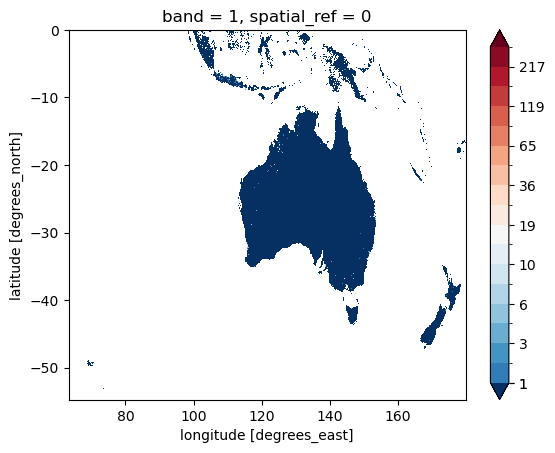

In [149]:
fig, ax = plt.subplots()
tile.squeeze().plot.imshow(ax = ax, levels = np.geomspace(1, test_subset.max(), num=20, dtype=int))

In [ ]:
# Save as Zarr
tile.to_zarr("Q:/HEALECON/Felix/Research/Heat Islands/data/test_processed.zarr", mode="w", consolidated=True)

---

In [106]:
test_boundary = gpd.read_file("Q:/HEALECON/Felix/Research/Heat Islands/data/ne_10m_admin_0_countries/ne_10m_admin_0_countries.shp", engine="pyogrio").query("ADMIN=='Papua New Guinea'")

test_boundary.bounds.iloc[0]

minx    140.849211
miny    -11.636326
maxx    155.967540
maxy     -1.346368
Name: 160, dtype: float64

<Axes: title={'center': 'band = 1, spatial_ref = 0'}, xlabel='longitude [degrees_east]', ylabel='latitude [degrees_north]'>

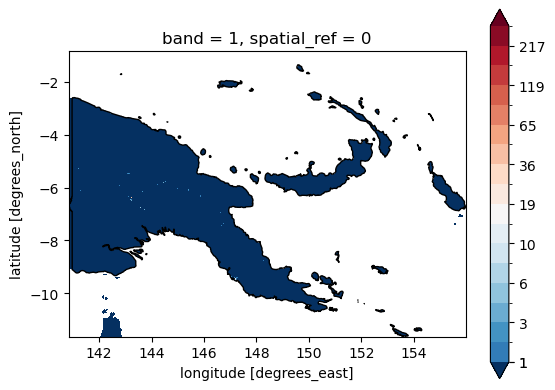

In [130]:
test_subset = test.rio.clip_box(*test_boundary.bounds.iloc[0])

fig, ax = plt.subplots()

test_subset.rio.clip([shoreline]).squeeze().plot.imshow(ax = ax, levels = np.geomspace(1, test_subset.max(), num=20, dtype=int))
test_boundary.plot(ax=ax, color = "none")

---

In [1]:
import xarray as xr
import rioxarray as rxr
import geopandas as gpd
import shapely
import matplotlib.pyplot as plt
import os
import numpy as np
from rasterio.enums import Resampling

# set root two directories up
os.chdir("../..")

In [2]:
# VIIRS (finest source)
viirs = rxr.open_rasterio("data/grid test/VNL_v22_npp-j01_2022_global_vcmslcfg_c202303062300.average_masked.dat.tif", chunks = "auto")
dmsp = rxr.open_rasterio("data/grid test/F121994.v4b.global.stable_lights.avg_vis.tif", chunks = "auto")
glass_modis = rxr.open_rasterio("data/grid test/GLASS06A01.V01.A2010001.h30v09.2021360.hdf", variable = "LST", decode_coords="all").rio.reproject(4326)
glass_avhrrr = rxr.open_rasterio("data/grid test/GLASS08B31.V40.A1982008.2021259.hdf", variable = "LST", decode_coords="all").rio.reproject(4326)

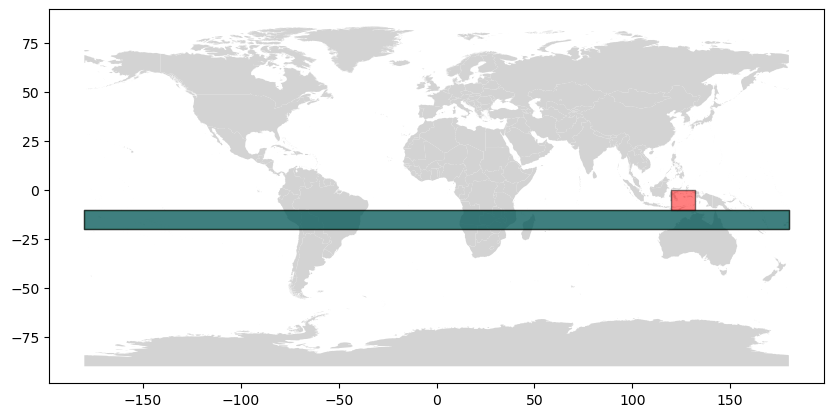

In [32]:
# modis grid: https://modis-land.gsfc.nasa.gov/MODLAND_grid.html

glass_modis_test1 = rxr.open_rasterio("data/grid test/GLASS06A01.V01.A2010001.h00v10.2021360.hdf", variable = "LST", decode_coords="all").rio.reproject(4326)
glass_modis_test2 = rxr.open_rasterio("data/grid test/GLASS06A01.V01.A2010001.h01v10.2021360.hdf", variable = "LST", decode_coords="all").rio.reproject(4326)
glass_modis_test3 = rxr.open_rasterio("data/grid test/GLASS06A01.V01.A2010001.h30v09.2021360.hdf", variable = "LST", decode_coords="all").rio.reproject(4326)

fig, ax = plt.subplots(figsize=(10, 5))
colors = ["blue", "green", "red", "orange"]

# plot world map
world = gpd.read_file("data/auxiliary/geography/ne_10m_admin_0_countries/ne_10m_admin_0_countries.shp", engine="pyogrio")
world.plot(ax=ax, color='lightgrey')

for idx, x in enumerate([glass_modis_test1, glass_modis_test2, glass_modis_test3]):
    gpd.GeoSeries([shapely.box(*x.rio.bounds())]).plot(ax = ax, color = colors[idx], alpha = 0.5, edgecolor = "black", label = f"glass_modis_test{idx+1}")

In [3]:
# bounds of Timor-Leste
timor_leste = gpd.read_file("data/auxiliary/geography/ne_10m_admin_0_countries/ne_10m_admin_0_countries.shp", engine="pyogrio").query("SOV_A3=='TLS'")
# floor lower bounds (0,1) / ceil upper bounds (2,3) to 0.5 degree
timor_leste_bounds = [
    np.floor(timor_leste.total_bounds[0] * 2) / 2,
    np.floor(timor_leste.total_bounds[1] * 2) / 2,
    np.ceil(timor_leste.total_bounds[2] * 2) / 2,
    np.ceil(timor_leste.total_bounds[3] * 2) / 2
]

In [4]:
viirs_subset = viirs.rio.clip_box(*timor_leste_bounds)
dmsp_subset = dmsp.rio.clip_box(*timor_leste_bounds)
glass_modis_subset = glass_modis.rio.clip_box(*timor_leste_bounds)
glass_avhrrr_subset = glass_avhrrr.rio.clip_box(*timor_leste_bounds)

In [52]:
template_crs = viirs_subset.spatial_ref.crs_wkt

In [88]:
resampled_raster_1 = resample_to_match(
    source_array=dmsp_subset, 
    template_array=viirs_subset,
    resampling_method=Resampling.cubic_spline,
)
# Resample coarse_raster to match fine_raster
resampled_raster_2 = resample_to_match(
    source_array=dmsp_subset, 
    target_crs = viirs_subset.spatial_ref.crs_wkt,
    target_shape= viirs_subset.shape[1:],
    target_transform = viirs_subset.rio.transform(),
    resampling_method=Resampling.cubic_spline,
)

In [1]:
import time
import rioxarray as rxr
import numpy as np
from rasterio.enums import Resampling
import pandas as pd
from scipy import stats
import os

# set root two directories up
os.chdir("../..")



In [2]:
def resample_to_match(source_array, template_array=None, target_crs=None, 
                      target_shape=None, target_transform=None, resampling_method=Resampling.bilinear):
    """
    Resamples a source xarray dataset or dataarray to match specified spatial properties.
    
    This function can work in two modes:
    1. Template-based: Reproject to match an existing template array
    2. Parameter-based: Reproject using explicitly specified CRS, resolution, and bounds
    
    Parameters
    ----------
    source_array : xarray.DataArray or xarray.Dataset
        The array to be resampled. Must have spatial dimensions and a valid CRS.
    template_array : xarray.DataArray or xarray.Dataset, optional
        The array whose spatial properties (resolution, extent, CRS) will be matched.
        If provided, this takes precedence over the other target parameters.
    target_crs : str or pyproj.CRS, optional
        The target coordinate reference system (e.g., 'EPSG:4326').
        Required if template_array is not provided.
    target_resolution : float or tuple of (float, float), optional
        The target resolution in units of target_crs.
        If float, the same resolution is used for x and y dimensions.
    resampling_method : rasterio.warp.Resampling, optional
        The resampling algorithm to use. Default is Resampling.bilinear.
    
    Returns
    -------
    xarray.DataArray or xarray.Dataset
        The resampled source array, matching the specified spatial properties.
    
    Examples
    --------
    >>> # Using a template array:
    >>> resampled = resample_to_match(source, template)
    >>> 
    >>> # Using explicit parameters:
    >>> resampled = resample_to_match(
    ...     source, 
    ...     target_crs='EPSG:4326',
    ...     target_bounds=(124.0, -10.0, 127.5, -8.0),
    ...     resampling_method=Resampling.cubic
    ... )
    """
    if template_array is not None:
        # Template-based resampling
        resampled = source_array.rio.reproject_match(
            template_array,
            resampling=resampling_method
        )
    else:
        # Parameter-based resampling
        if target_crs is None:
            raise ValueError("Either template_array or target_crs must be provided")
        
        # Perform the resampling
        resampled = source_array.rio.reproject(
            dst_crs=target_crs,
            shape=target_shape,
            transform=target_transform,
            resampling=resampling_method
        )
    
    return resampled

<Axes: title={'center': 'band = 1, spatial_ref = 0'}, xlabel='longitude [degrees_east]', ylabel='latitude [degrees_north]'>

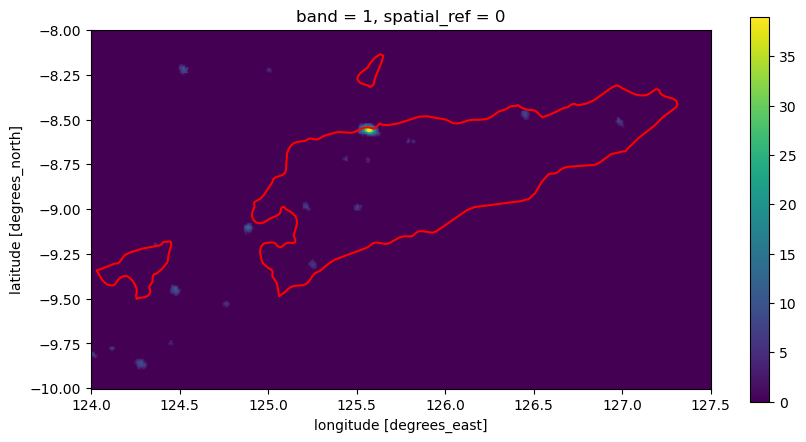

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))
resampled_raster.squeeze().plot.imshow(ax=ax)
# plot map of Timor-Leste
timor_leste.boundary.plot(ax=ax, color = "red")

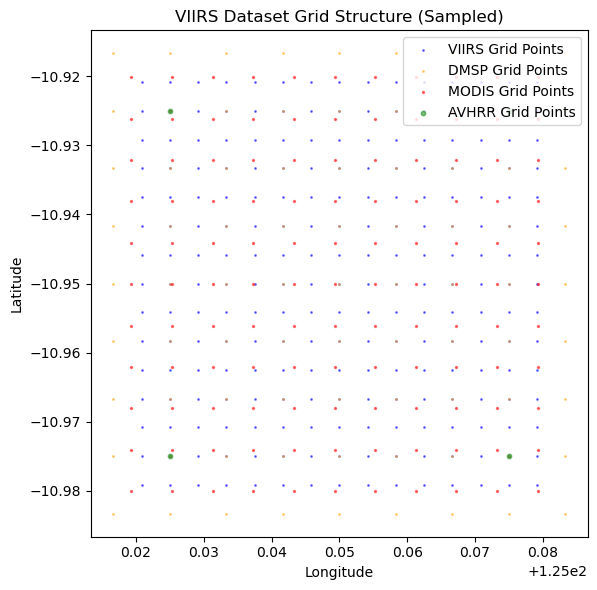

In [ ]:
# Sample a subset of the VIIRS grid to visualize as points
# (Using the full dataset would be too dense to view)

# Create a figure
fig, ax = plt.subplots(figsize=(10, 6))

# Create a function to sample and visualize grid points from a dataset
def plot_grid_sample(dataset, color='blue', markersize = 1, label='Grid Points', clip_box=None):

    sample_x = dataset.rio.clip_box(*clip_box).x.values
    sample_y = dataset.rio.clip_box(*clip_box).y.values
    
    xx, yy = np.meshgrid(sample_x, sample_y)
    points_array = np.column_stack((xx.ravel(), yy.ravel()))
    gdf_points = gpd.GeoSeries([shapely.Point(x, y) for x, y in points_array], crs="EPSG:4326")
    
    # Plot the points
    gdf_points.plot(ax=ax, markersize=markersize, alpha=0.5, color=color, label=label)
    
    return gdf_points

# Prepare clip to Timor-Leste
clip_box = [125.02, -10.98, 125.08, -10.92]#[125, -9.5, 125.5, -9]

# Apply the function to visualize VIIRS grid
viirs_points = plot_grid_sample(viirs, color='blue', label='VIIRS Grid Points', clip_box=clip_box)
dmsp_points = plot_grid_sample(dmsp, color='orange', markersize = 1, label='DMSP Grid Points', clip_box=clip_box)
glass_modis_points = plot_grid_sample(glass_modis, color='red', markersize = 2, label='MODIS Grid Points', clip_box=clip_box)
glass_avhrrr_points = plot_grid_sample(glass_avhrrr, color='green', markersize = 10, label='AVHRR Grid Points', clip_box=clip_box)

# # Add country boundaries for reference
# world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'), engine="pyogrio").query("iso_a3=='TLS'")
# world.plot(ax=ax, color='none', edgecolor='gray', linewidth=0.5, alpha=0.5)

# Set labels and title
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('VIIRS Dataset Grid Structure (Sampled)')

# Add legend
ax.legend()

plt.tight_layout()
plt.show()

fig.savefig("data/grid test/grid_test.png", dpi=300, bbox_inches='tight')

Testing Timor (7.00 sq. deg.) with 20 repetitions...
  Completed 10/20 iterations
  Completed 20/20 iterations
Area: Timor, Size: 7.00 sq. deg., Mean Runtime: 2.1796 ± 0.1516 seconds, Peak Memory: 217.10 MB, Memory Increase: 1.33 MB
Testing Timor (7.00 sq. deg.) with 20 repetitions...
  Completed 10/20 iterations
  Completed 20/20 iterations
Area: Timor, Size: 7.00 sq. deg., Mean Runtime: 2.1450 ± 0.0921 seconds, Peak Memory: 381.73 MB, Memory Increase: 0.04 MB
Testing 2x Area (16.00 sq. deg.) with 20 repetitions...
  Completed 10/20 iterations
  Completed 20/20 iterations
Area: 2x Area, Size: 16.00 sq. deg., Mean Runtime: 2.2573 ± 0.0491 seconds, Peak Memory: 396.83 MB, Memory Increase: 0.23 MB
Testing 2x Area (16.00 sq. deg.) with 20 repetitions...
  Completed 10/20 iterations
  Completed 20/20 iterations
Area: 2x Area, Size: 16.00 sq. deg., Mean Runtime: 2.3329 ± 0.0930 seconds, Peak Memory: 562.34 MB, Memory Increase: 0.33 MB
Testing 4x Area (36.00 sq. deg.) with 20 repetitions...


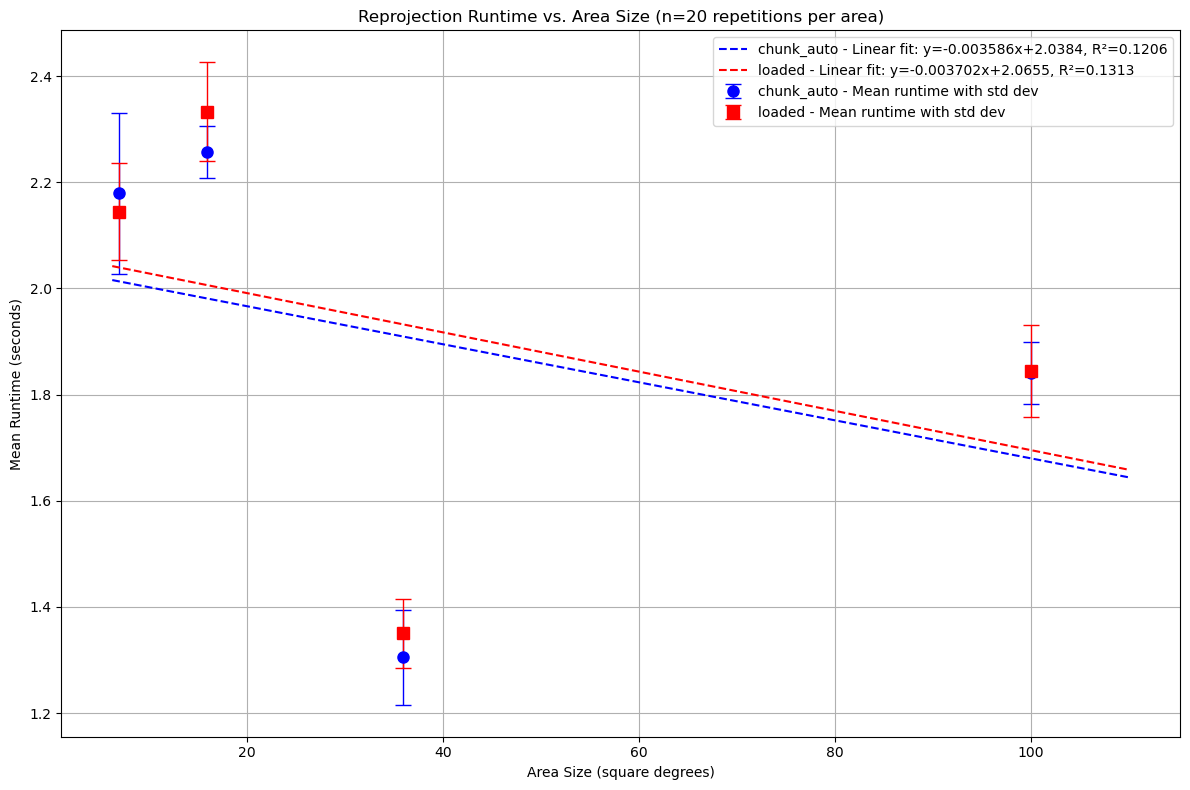

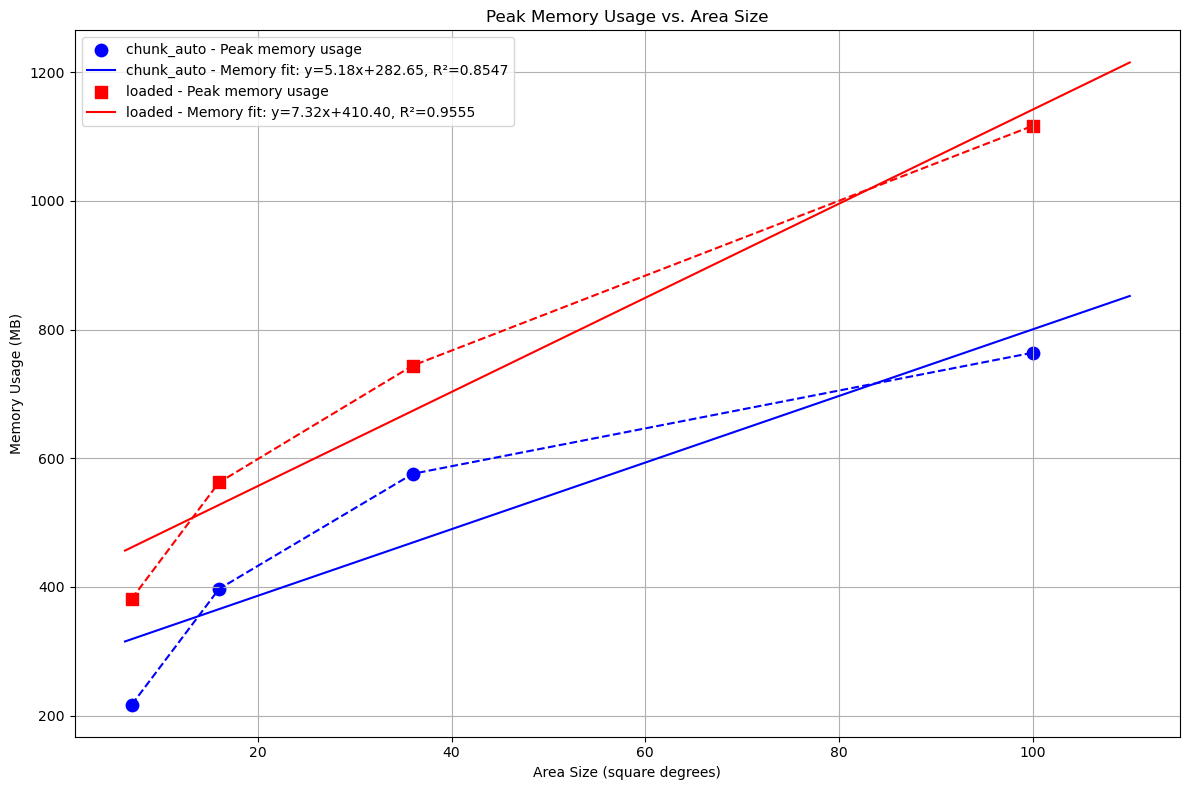


Area vs Resource scaling for chunk_auto:
2x Area: Area 2.29x, Runtime 1.04x (Ratio: 0.45), Memory 1.83x (Ratio: 0.80)
4x Area: Area 5.14x, Runtime 0.60x (Ratio: 0.12), Memory 2.65x (Ratio: 0.52)
8x Area: Area 14.29x, Runtime 0.84x (Ratio: 0.06), Memory 3.52x (Ratio: 0.25)

Area vs Resource scaling for loaded:
2x Area: Area 2.29x, Runtime 1.09x (Ratio: 0.48), Memory 1.47x (Ratio: 0.64)
4x Area: Area 5.14x, Runtime 0.63x (Ratio: 0.12), Memory 1.95x (Ratio: 0.38)
8x Area: Area 14.29x, Runtime 0.86x (Ratio: 0.06), Memory 2.93x (Ratio: 0.20)


In [3]:
import os
import time
import numpy as np
import pandas as pd
from scipy import stats
import psutil
from memory_profiler import memory_usage

# Define testing areas of different sizes
test_areas = {
    "Timor": [124.0, -10.0, 127.5, -8.0],  # Our reference (already defined)
    "2x Area": [124.0, -11.0, 128.0, -7.0],  # Roughly 2x the area
    "4x Area": [123.0, -12.0, 129.0, -6.0],  # Roughly 4x the area
    "8x Area": [121.0, -14.0, 131.0, -4.0]   # Roughly 8x the area
}

modes = ["chunk_auto", "loaded"]

# Results dictionary
results = {mode: {
    "area_name": [],
    "area_size": [],
    "runtime_mean": [],
    "runtime_std": [],
    "memory_mean": [],   # Adding memory metrics
    "memory_peak": [],   # Adding peak memory usage
    "memory_diff": []    # Adding memory increase during operation
} for mode in modes}

# Number of repetitions for each area
n_repeats = 20

# load data
viirs = rxr.open_rasterio("data/grid test/VNL_v22_npp-j01_2022_global_vcmslcfg_c202303062300.average_masked.dat.tif", chunks="auto")
dmsp = rxr.open_rasterio("data/grid test/F121994.v4b.global.stable_lights.avg_vis.tif", chunks="auto")

# Function to run the resample operation with memory profiling
def run_resample(source, target):
    def _resample():
        _ = resample_to_match(
            source_array=source,
            template_array=target,
            resampling_method=Resampling.cubic_spline
        )
    
    # Track memory usage during resample operation
    mem_usage = memory_usage(_resample, interval=0.1, timeout=60)
    return mem_usage

# Run timing tests for each area
for area_name, bounds in test_areas.items():
    # Calculate approximate area in square degrees
    area_size = (bounds[2] - bounds[0]) * (bounds[3] - bounds[1])
    
    for mode in modes:
        if mode == "chunk_auto":
            # Load the data with automatic chunking
            source = dmsp.rio.clip_box(*bounds)
            target = viirs.rio.clip_box(*bounds)
            
        elif mode == "loaded":
            # Load the data with explicit chunking
            source = dmsp.rio.clip_box(*bounds).load()
            target = viirs.rio.clip_box(*bounds).load()
    
        # Run multiple trials for this area
        runtimes = []
        memory_means = []
        memory_peaks = []
        memory_diffs = []
        
        print(f"Testing {area_name} ({area_size:.2f} sq. deg.) with {n_repeats} repetitions...")
        
        for i in range(n_repeats):
            # Time and memory profile the resampling operation
            start_time = time.time()
            mem_usage = run_resample(source, target)
            end_time = time.time()
            
            # Calculate memory metrics
            mem_baseline = mem_usage[0]  # Starting memory
            mem_peak = max(mem_usage)    # Peak memory
            mem_diff = mem_peak - mem_baseline  # Memory increase
            mem_mean = np.mean(mem_usage)  # Average memory during operation
            
            # Store results
            runtimes.append(end_time - start_time)
            memory_means.append(mem_mean)
            memory_peaks.append(mem_peak)
            memory_diffs.append(mem_diff)
            
            # Progress update every 10 iterations
            if (i+1) % 10 == 0:
                print(f"  Completed {i+1}/{n_repeats} iterations")
        
        # Record results
        results[mode]["area_name"].append(area_name)
        results[mode]["area_size"].append(area_size)
        results[mode]["runtime_mean"].append(np.mean(runtimes))
        results[mode]["runtime_std"].append(np.std(runtimes))
        results[mode]["memory_mean"].append(np.mean(memory_means))
        results[mode]["memory_peak"].append(np.mean(memory_peaks))
        results[mode]["memory_diff"].append(np.mean(memory_diffs))
        
        print(f"Area: {area_name}, Size: {area_size:.2f} sq. deg., " 
              f"Mean Runtime: {results[mode]['runtime_mean'][-1]:.4f} ± {results[mode]['runtime_std'][-1]:.4f} seconds, "
              f"Peak Memory: {results[mode]['memory_peak'][-1]:.2f} MB, "
              f"Memory Increase: {results[mode]['memory_diff'][-1]:.2f} MB")

# Create DataFrames from results
results_dfs = {}
for mode in modes:
    results_dfs[mode] = pd.DataFrame({
        "area_name": results[mode]["area_name"],
        "area_size": results[mode]["area_size"],
        "runtime_mean": results[mode]["runtime_mean"],
        "runtime_std": results[mode]["runtime_std"],
        "memory_mean": results[mode]["memory_mean"],
        "memory_peak": results[mode]["memory_peak"],
        "memory_diff": results[mode]["memory_diff"]
    })
    print(f"\nSummary of results for {mode}:")
    print(results_dfs[mode])

# Plot results to visualize the relationship for each mode
import matplotlib.pyplot as plt

# Runtime plot
plt.figure(figsize=(12, 8))
colors = ['blue', 'red']
markers = ['o', 's']

for i, mode in enumerate(modes):
    df = results_dfs[mode]
    plt.errorbar(df["area_size"], df["runtime_mean"], 
                yerr=df["runtime_std"], fmt=markers[i], color=colors[i], markersize=8, 
                capsize=6, elinewidth=1, label=f'{mode} - Mean runtime with std dev')

    # Add trend line
    slope, intercept, r_value, p_value, std_err = stats.linregress(df["area_size"], df["runtime_mean"])
    x_line = np.linspace(min(df["area_size"])*0.9, max(df["area_size"])*1.1, 100)
    plt.plot(x_line, intercept + slope * x_line, '--', color=colors[i], 
            label=f'{mode} - Linear fit: y={slope:.6f}x+{intercept:.4f}, R²={r_value**2:.4f}')

plt.xlabel('Area Size (square degrees)')
plt.ylabel('Mean Runtime (seconds)')
plt.title('Reprojection Runtime vs. Area Size (n=20 repetitions per area)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Memory usage plot
plt.figure(figsize=(12, 8))

for i, mode in enumerate(modes):
    df = results_dfs[mode]
    plt.scatter(df["area_size"], df["memory_peak"], marker=markers[i], color=colors[i], s=80, 
                label=f'{mode} - Peak memory usage')
    plt.plot(df["area_size"], df["memory_peak"], '--', color=colors[i])
    
    # Add trend line for memory
    slope, intercept, r_value, p_value, std_err = stats.linregress(df["area_size"], df["memory_peak"])
    plt.plot(x_line, intercept + slope * x_line, '-', color=colors[i], 
            label=f'{mode} - Memory fit: y={slope:.2f}x+{intercept:.2f}, R²={r_value**2:.4f}')

plt.xlabel('Area Size (square degrees)')
plt.ylabel('Memory Usage (MB)')
plt.title('Peak Memory Usage vs. Area Size')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Calculate the ratio of runtime and memory increase vs area increase for each mode
for mode in modes:
    df = results_dfs[mode]
    print(f"\nArea vs Resource scaling for {mode}:")
    base_area = df["area_size"][0]
    base_runtime = df["runtime_mean"][0]
    base_memory = df["memory_peak"][0]

    for i in range(1, len(df)):
        area_ratio = df["area_size"][i] / base_area
        runtime_ratio = df["runtime_mean"][i] / base_runtime
        memory_ratio = df["memory_peak"][i] / base_memory
        
        print(f"{df['area_name'][i]}: Area {area_ratio:.2f}x, "
              f"Runtime {runtime_ratio:.2f}x (Ratio: {runtime_ratio/area_ratio:.2f}), "
              f"Memory {memory_ratio:.2f}x (Ratio: {memory_ratio/area_ratio:.2f})")

In [ ]:
((2**13  - 282.65) / 5.18) ** .5
# For 8GB RAM, we want to use a maximum window size of 39 degrees, 35 with comfortable memory usage

39.07558757589634

In [ ]:
# create the master grid
# extent of the world:
world_bounds = [0, 70, 0, 70]# world_bounds = [-180, -90, 180, 90]


---

# Step 1: Annual summarization

- Get single indicator for single year
- Remain in source CRS
- Not necessary for all sources

- Idea: Maintain source structure

In [107]:
import xarray as xr
import rioxarray as rxr

In [188]:
modis = rxr.open_rasterio("/Users/felixschulz/Library/CloudStorage/OneDrive-Personal/Dokumente/Job/UNI/Basel/Research/growth-and-temperature/data/glass_LST_MODIS_Daily_1KM_GLASS06A01.V01.A2000055.h00v10.2022021.hdf")

In [254]:
modis.rio.crs

CRS.from_wkt('PROJCS["unnamed",GEOGCS["Unknown datum based upon the custom spheroid",DATUM["Not specified (based on custom spheroid)",SPHEROID["Custom spheroid",6371007.181,0]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]]],PROJECTION["Sinusoidal"],PARAMETER["longitude_of_center",0],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["Meter",1],AXIS["Easting",EAST],AXIS["Northing",NORTH]]')

In [199]:
grid_settings = {
    "glass/LST/MODIS/Daily/1KM": {
        "crs_wkt": modis.rio.crs.to_wkt(),
        "resolution": modis.rio.resolution(),
    },
}

In [197]:
import json
with open("data/blank_grids/grid_settings.json", "w") as f:
    json.dump(grid_settings, f, indent=4)

In [195]:
# Function to create a grid of NaN values covering the world in WGS84 and reproject it
def create_grid(store, crs_wkt, resolution):
    """
    Create a grid of NaN values covering the world in WGS84 and reproject it to a specified CRS.

    Parameters:
    -----------
    store : str
        Path to the output Zarr store where the grid will be saved.
    crs_wkt : str
        The target coordinate reference system (CRS) in WKT format.
    resolution : float or tuple
        The resolution of the grid in the target CRS. If a single float is provided, it is applied to both x and y dimensions.

    Returns:
    --------
    None
        The function saves the reprojected grid to the specified Zarr store.

    Notes:
    ------
    - The initial grid is created in WGS84 CRS with 1-degree resolution.
    - The grid is filled with NaN values and reprojected to the specified CRS and resolution.
    - The reprojected grid is saved as a Zarr file for efficient storage and access.
    """
    # Define the bounds of the world in WGS84 (longitude and latitude)
    bounds = [-180, 180, -90, 90]
    
    # Create x and y coordinates with 1-degree resolution
    x = np.arange(bounds[0], bounds[1], 1)
    y = np.arange(bounds[2], bounds[3], 1)
    
    # Create a 2D grid filled with NaN values
    grid = np.full((len(y), len(x)), np.nan)
    
    # Create an xarray.DataArray with the grid
    grid_xr = xr.DataArray(
        grid,
        coords={"y": y, "x": x},  # Assign coordinates
        dims=["y", "x"],          # Define dimensions
        name="grid",              # Name the DataArray
    )
    
    # Set spatial dimensions and CRS for the grid
    grid_xr = grid_xr.rio.set_spatial_dims(x_dim="x", y_dim="y")
    grid_xr = grid_xr.rio.write_crs("EPSG:4326", inplace=True)  # Write WGS84 CRS
    grid_xr = grid_xr.rio.set_nodata(np.nan)  # Set NaN as the no-data value
    grid_xr = grid_xr.rio.write_transform()  # Write the affine transform
    
    # Reproject the grid to the target CRS and resolution, and save it as a Zarr file
    grid_xr.rio.reproject(
        dst_crs=crs_wkt,          # Target CRS in WKT format
        resolution=resolution,    # Target resolution
    ).to_zarr(store, mode="w", consolidated=True)  # Save to Zarr store

In [ ]:
from odc.geo.geobox import GeoBox
from odc.geo.xr import ODCExtensionDa, xr_zeros

# Function to create a grid of NaN values covering the world in WGS84 and reproject it
def create_grid(store, crs_wkt, resolution):
    """
    Create a grid of NaN values covering the world in WGS84 and reproject it to a specified CRS.

    Parameters:
    -----------
    store : str
        Path to the output Zarr store where the grid will be saved.
    crs_wkt : str
        The target coordinate reference system (CRS) in WKT format.
    resolution : float or tuple
        The resolution of the grid in the target CRS. If a single float is provided, it is applied to both x and y dimensions.

    Returns:
    --------
    None
        The function saves the reprojected grid to the specified Zarr store.

    Notes:
    ------
    - The initial grid is created in WGS84 CRS with 1-degree resolution.
    - The grid is filled with NaN values and reprojected to the specified CRS and resolution.
    - The reprojected grid is saved as a Zarr file for efficient storage and access.
    """
    # Define the bounds of the world in WGS84 (longitude and latitude)
    bounds = [-180, 180, -90, 90]
    
    grid_xr = xr_zeros(
        GeoBox.from_bbox(
            (-180, -90, 180, 90), "epsg:4326", resolution=1
        ),
        chunks="auto",
    )
    
    # Reproject the grid to the target CRS and resolution, and save it as a Zarr file
    return grid_xr.odc.reproject(
        crs_wkt,          # Target CRS in WKT format
        resolution=resolution[0],    # Target resolution
    )#.to_zarr(store, mode="w", consolidated=True)  # Save to Zarr store
    #
test = create_grid("data/blank_grids/test.zarr", modis.rio.crs.to_wkt(), modis.rio.resolution())

GEOSException: TopologyException: side location conflict at -6.1106675275368616e-13 91.147717989650729. This can occur if the input geometry is invalid.

In [ ]:
import pandas as pd
import geopandas as gpd
import shapely
# Read the data, skipping header and footer lines
modland_grid = pd.read_csv(
    "https://modis-land.gsfc.nasa.gov/pdf/sn_bound_10deg.txt",
    sep="\s+",
    skiprows=7,
    skipfooter=3,
    engine='python',
    names=['iv', 'ih', 'lon_min', 'lon_max', 'lat_min', 'lat_max']
)

# turn into geodataframe
modland_grid = gpd.GeoDataFrame(
    modland_grid,
    geometry=[
        shapely.box(row.lon_min, row.lat_min, row.lon_max, row.lat_max)
        for _, row in modland_grid.iterrows()
    ],
    crs=4326
)

In [200]:
create_grid(
    "data/blank_grids/glass/LST/MODIS/Daily/1KM.zarr", 
    grid_settings["glass/LST/MODIS/Daily/1KM"]["crs_wkt"],
    grid_settings["glass/LST/MODIS/Daily/1KM"]["resolution"]
    )

---

In [7]:
from google.cloud import storage
from google.oauth2 import service_account

In [8]:
# get files in the directory
#credentials = service_account.Credentials.from_service_account_file('Q:/HEALECON/Felix/Research/Heat Islands/misc/ee-growthandheat-570de7e75ef6.json')
storage_client = storage.Client()#credentials=credentials)

In [ ]:
# blobs = storage_client.list_blobs("growthandheat", prefix="glass/LST/MODIS/Daily/1KM/")
# MODIS_files = list(blobs)
# MODIS_files_names = [x.name for x in MODIS_files]
# import pickle
# # write MODIS files to pickle
# pickle.dump(MODIS_files_names, open("Q:/HEALECON/Felix/Research/Heat Islands/data/MODIS_files_names.pkl", "wb"))

In [1]:
import pickle
import pandas as pd
import os 
# set root two directories up
os.chdir("../..")

In [2]:
# import MODIS file paths from pickle
MODIS_files_names = pickle.load(open("data/MODIS_files_names.pkl", "rb"))
# remove the first element (it is a directory)
MODIS_files_names = pd.Series(MODIS_files_names)[1:]
# turn into DF
MODIS_files_names = MODIS_files_names.to_frame("path")

In [3]:
## extract grid information
# check if all files have the expected naming convention
if not MODIS_files_names.path.str.contains(r"h\d{2}v\d{2}", regex = True).all():
    raise ValueError("Not all files have the expected naming convention")
# extract h and v from the file names
MODIS_files_names[["h", "v"]] = MODIS_files_names.path.str.extract(r"h(\d{2})v(\d{2})", expand = True).astype(int)

In [4]:
## extract date information
# check if all files have the expected naming convention
if not MODIS_files_names.path.str.contains(r"A\d{7}", regex = True).all():
    raise ValueError("Not all files have the expected naming convention")
# extract date from the file names
MODIS_files_names[["year", "day"]] = MODIS_files_names.path.str.extract(r"A(\d{4})(\d{3})", expand = True).astype(int)

In [70]:
cyear = 2001
query_files = MODIS_files_names.query(f"h==30 & v==9 & year=={cyear}").tail(10)

In [ ]:
import tempfile
import xarray as xr
import rioxarray as rxr

# create temporary directory
with tempfile.TemporaryDirectory() as temp_dir:
    crosssections = [None] * len(query_files)
    # download and import files
    for ifile, file in enumerate(query_files.path):
        blob = storage_client.bucket("growthandheat").blob(file)
        blob.download_to_filename(os.path.join(temp_dir, os.path.basename(file)))
        crosssections[ifile] = rxr.open_rasterio(os.path.join(temp_dir, os.path.basename(file)), variable = "LST", decode_coords="all")
        
    crosssections = xr.concat(crosssections, dim = query_files.day)
    crosssections = crosssections.rename({"day": "time"})
    crosssections["time"] = pd.to_datetime([f"{str(cyear)}{x}" for x in crosssections["time"].values], format="%Y%j").values
    
    # calculate monthly mean, median, std, and non-missing count
    monthly = xr.Dataset({
        "mean": crosssections.resample(time="1ME").mean(),
        "median": crosssections.resample(time="1ME").median(),
        "std": crosssections.resample(time="1ME").std(),
        "count": (~crosssections.isnull()).resample(time="1ME").sum()
    })
    
    annual = xr.Dataset({
        "mean": crosssections.resample(time="1YE").mean(),
        "median": crosssections.resample(time="1YE").median()
    })

/Users/felixschulz/miniforge3/envs/thesis/lib/python3.9/site-packages/xarray/groupers.py:326: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  self.index_grouper = pd.Grouper(
/Users/felixschulz/miniforge3/envs/thesis/lib/python3.9/site-packages/xarray/groupers.py:326: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  self.index_grouper = pd.Grouper(


In [202]:
write_grid = xr.open_zarr("data/blank_grids/glass/LST/MODIS/Daily/1KM.zarr", decode_coords="all", chunks="auto")

In [206]:
test = xr.merge([write_grid, annual], join="left")

In [227]:
np.isin(annual.x[0].values, test.x.values)

array(False)

In [229]:
annual.x[0].values

array(13343869.54871653)

In [228]:
test.x.values

array([-20013866.96267397, -20012940.33724091, -20012013.71180786, ...,
        19990406.23321246,  19991332.85864551,  19992259.48407856])

In [215]:
test_reproject_25 = test.squeeze().rio.reproject(
    dst_crs=test.rio.crs,
    resolution=tuple([x * 4 for x in test.rio.resolution()]),
)

In [218]:
test_reproject_25["mean"].isnull().all()

<xarray.DataArray 'mean' ()> Size: 1B
array(True)
Coordinates:
    band         int64 8B 1
    time         datetime64[ns] 8B 2001-12-31
    spatial_ref  int64 8B 0

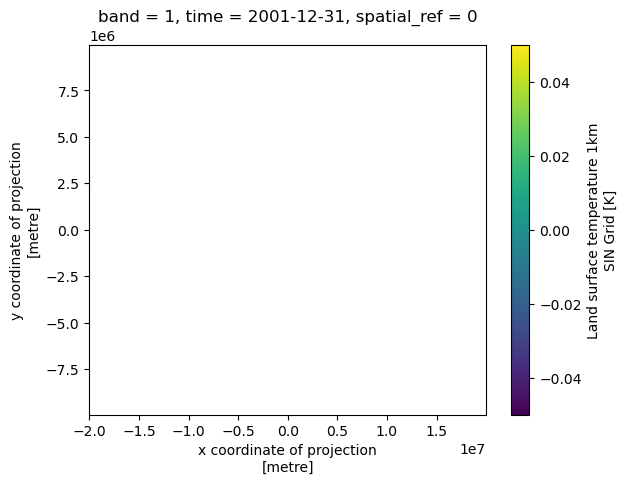

In [217]:
test_reproject_25["mean"].plot.imshow()

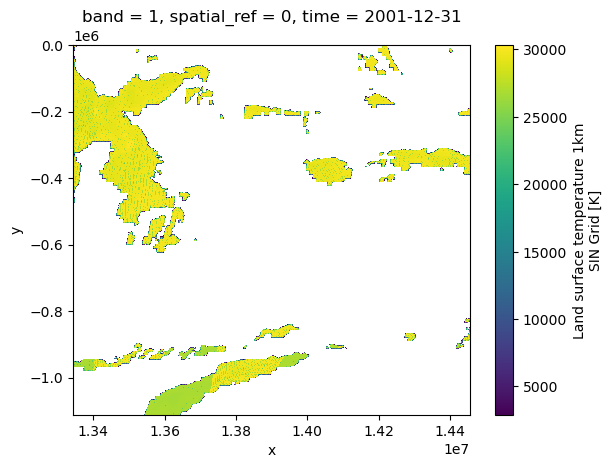

In [106]:
annual["mean"].where(annual["mean"] > 0).squeeze().plot.imshow()

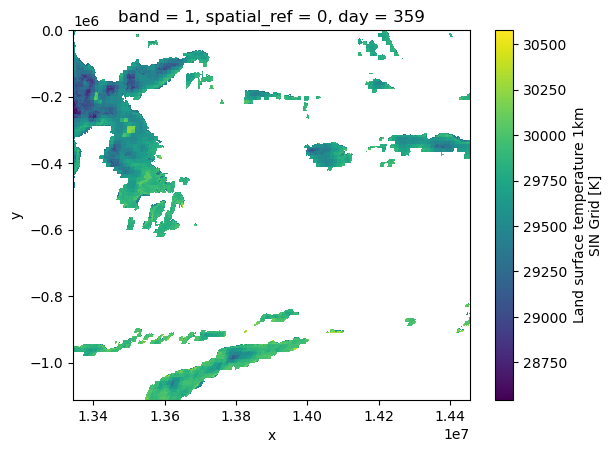

In [37]:
crosssections.where(crosssections > 0).isel(day=3).squeeze().plot.imshow()

In [38]:
365**2

133225

In [40]:
import numpy as np
np.iinfo(np.uint32)

iinfo(min=0, max=4294967295, dtype=uint32)

In [2]:
from osgeo import gdal

def get_gdal_driver(filepath):
    dataset = gdal.Open(filepath)
    if dataset is None:
        return "Could not open file"
    
    driver = dataset.GetDriver()
    driver_name = driver.ShortName
    driver_long_name = driver.LongName
    
    return f"Driver Short Name: {driver_name}\nDriver Long Name: {driver_long_name}"

# Example usage
filepath = "/Users/felixschulz/Downloads/GLASS08B31.V40.A2000045.2021250.hdf"
print(get_gdal_driver(filepath))

Driver Short Name: HDF4
Driver Long Name: Hierarchical Data Format Release 4


In [ ]:
import rioxarray as rxr
rxr.open_rasterio("/Users/felixschulz/Downloads/GLASS08B31.V40.A2000045.2021250.hdf", variable = "LST", decode_coords="all")

<xarray.Dataset> Size: 52MB
Dimensions:      (band: 1, x: 7200, y: 3600)
Coordinates:
  * band         (band) int64 8B 1
  * x            (x) float64 58kB -180.0 -179.9 -179.9 ... 179.9 179.9 180.0
  * y            (y) float64 29kB 89.97 89.92 89.88 ... -89.88 -89.93 -89.98
    spatial_ref  int64 8B 0
Data variables:
    LST          (band, y, x) uint16 52MB ...
Attributes: (12/40)
    ASSOCIATEDINSTRUMENTSHORTNAME.1:  AVHRR
    ASSOCIATEDPLATFORMSHORTNAME.1:    NOAA
    ASSOCIATEDSENSORSHORTNAME.1:      AVHRR
    CHARACTERISTICBINSIZE:            926.6
    DATACOLUMNS:                      7200
    DATAROWS:                         3600
    ...                               ...
    SOUTHBOUNDINGCOORDINATE:          -90
    TILENUMBER:                       H00V00
    VERSIONID:                        1
    VERTICALTILENUMBER:               0
    WEBSITE:                          http://glass-product.bnu.edu.cn
    WESTHBOUNDINGCOORDINATE:          -180